# NB02: Essential Gene Families

Classify ortholog families by essentiality pattern across 48 Fitness Browser organisms.

**Input**: `data/all_essential_genes.tsv`, `data/all_ortholog_groups.csv` (from `src/extract_data.py`)
**Output**: `data/essential_families.tsv`, figures

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA_DIR = Path('../data')
FIG_DIR = Path('../figures')
FIG_DIR.mkdir(parents=True, exist_ok=True)

essential = pd.read_csv(DATA_DIR / 'all_essential_genes.tsv', sep='\t', low_memory=False)
essential['is_essential'] = essential['is_essential'].astype(str).str.strip().str.lower() == 'true'
essential['locusId'] = essential['locusId'].astype(str)

og_df = pd.read_csv(DATA_DIR / 'all_ortholog_groups.csv')
og_df['locusId'] = og_df['locusId'].astype(str)

seed_ann = pd.read_csv(DATA_DIR / 'all_seed_annotations.tsv', sep='\t')

# SEED hierarchy from upstream project
seed_hier_path = Path('../../conservation_vs_fitness/data/seed_hierarchy.tsv')
seed_hier = pd.read_csv(seed_hier_path, sep='\t') if seed_hier_path.exists() else None

print(f"Genes: {len(essential):,} ({essential['is_essential'].sum():,} essential, {essential['is_essential'].mean()*100:.1f}%)")
print(f"Ortholog groups: {og_df['OG_id'].nunique():,}")
print(f"Organisms: {essential['orgId'].nunique()}")

Genes: 221,005 (41,059 essential, 18.6%)
Ortholog groups: 17,222
Organisms: 48


## Merge essentiality with ortholog groups

In [2]:
# Merge OG membership into essential gene table
merged = og_df.merge(
    essential[['orgId', 'locusId', 'is_essential', 'gene', 'desc', 'gene_length']],
    on=['orgId', 'locusId'], how='left'
)

# Tag genes that have orthologs
og_keys = og_df[['orgId', 'locusId']].drop_duplicates()
og_keys['in_og'] = True
essential = essential.merge(og_keys, on=['orgId', 'locusId'], how='left')
essential['in_og'] = essential['in_og'].fillna(False).astype(bool)

assert essential['in_og'].sum() > 30000, f"in_og merge failed: only {essential['in_og'].sum()} matches"
assert len(essential) == 221005, f"Merge created duplicates: {len(essential)}"

ess_in_og = essential[essential['is_essential'] & essential['in_og']]
ess_not_in_og = essential[essential['is_essential'] & ~essential['in_og']]

print(f"Genes with orthologs: {essential['in_og'].sum():,} / {len(essential):,}")
print(f"Essential with orthologs: {len(ess_in_og):,}")
print(f"Essential orphans (no orthologs): {len(ess_not_in_og):,}")

Genes with orthologs: 179,223 / 221,005
Essential with orthologs: 33,975
Essential orphans (no orthologs): 7,084


## Classify ortholog families

For each ortholog group, determine:
- How many organisms have essential members vs non-essential
- **Universally essential**: essential in ALL organisms where family has members
- **Variably essential**: essential in some, non-essential in others
- **Never essential**: no essential members

In [3]:
family_stats = []
for og_id, group in merged.groupby('OG_id'):
    with_status = group[group['is_essential'].notna()].copy()
    if len(with_status) == 0:
        continue
    with_status['is_essential'] = with_status['is_essential'].astype(bool)

    n_organisms = with_status['orgId'].nunique()
    n_essential = with_status[with_status['is_essential'] == True]['orgId'].nunique()
    n_nonessential = with_status[with_status['is_essential'] == False]['orgId'].nunique()
    n_genes = len(with_status)
    n_ess_genes = (with_status['is_essential'] == True).sum()

    descs = with_status['desc'].dropna().unique()
    non_hyp = [d for d in descs if 'hypothetical' not in str(d).lower()]
    rep_desc = non_hyp[0] if non_hyp else (descs[0] if len(descs) > 0 else 'unknown')
    gene_names = [g for g in with_status['gene'].dropna().unique() if g and str(g) != 'nan']
    rep_gene = gene_names[0] if gene_names else ''

    if n_essential == n_organisms:
        ess_class = 'universally_essential'
    elif n_essential > 0:
        ess_class = 'variably_essential'
    else:
        ess_class = 'never_essential'

    ess_orgs = sorted(with_status[with_status['is_essential'] == True]['orgId'].unique())
    noness_orgs = sorted(with_status[with_status['is_essential'] == False]['orgId'].unique())

    family_stats.append({
        'OG_id': og_id, 'n_organisms': n_organisms,
        'n_essential_organisms': n_essential, 'n_nonessential_organisms': n_nonessential,
        'n_genes': n_genes, 'n_essential_genes': int(n_ess_genes),
        'frac_essential': n_essential / n_organisms,
        'essentiality_class': ess_class, 'rep_gene': rep_gene, 'rep_desc': rep_desc,
        'essential_organisms': ';'.join(ess_orgs),
        'nonessential_organisms': ';'.join(noness_orgs),
    })

families = pd.DataFrame(family_stats)
families['copy_ratio'] = families['n_genes'] / families['n_organisms']
families['is_single_copy'] = (families['copy_ratio'] <= 1.5) & (families['n_nonessential_organisms'] == 0)

families.to_csv(DATA_DIR / 'essential_families.tsv', sep='\t', index=False)
print(f"Classified {len(families):,} ortholog families")

Classified 17,222 ortholog families


## Family classification summary

In [4]:
class_counts = families['essentiality_class'].value_counts()
for cls, count in class_counts.items():
    print(f"  {cls}: {count:,} ({count/len(families)*100:.1f}%)")

univ = families[families['essentiality_class'] == 'universally_essential']
print(f"\nUniversally essential: {len(univ)} total")
print(f"  Single-copy (strict): {univ['is_single_copy'].sum()}")
print(f"  Multi-copy/paralog: {len(univ) - univ['is_single_copy'].sum()}")
print(f"  Essential in ALL 48 organisms: {(univ['n_organisms'] == 48).sum()}")

  never_essential: 11,564 (67.1%)
  variably_essential: 4,799 (27.9%)
  universally_essential: 859 (5.0%)

Universally essential: 859 total
  Single-copy (strict): 839
  Multi-copy/paralog: 20
  Essential in ALL 48 organisms: 15


## Top 30 universally essential families

In [5]:
top = univ.sort_values('n_organisms', ascending=False).head(30)
display_df = top[['OG_id', 'n_organisms', 'rep_gene', 'rep_desc', 'copy_ratio']].copy()
display_df.columns = ['OG', 'Organisms', 'Gene', 'Description', 'Copy ratio']
display_df['Description'] = display_df['Description'].str[:55]
display_df

,OG,Organisms,Gene,Description,Copy ratio
546,OG00546,48,rpsC,30S ribosomal protein S3,1.000000
1241,OG01241,48,rps11,30S ribosomal protein S11 (RefSeq),1.000000
1350,OG01350,48,rplW,Ribosomal protein L23,1.000000
632,OG00632,48,rplK,LSU ribosomal protein L11p (L12e),1.000000
1203,OG01203,48,groEL,"chaperonin, 60 kDa (TIGR)",1.145833
1586,OG01586,48,pyrG,CTP synthase,1.000000
1758,OG01758,48,valS,valyl-tRNA synthetase (RefSeq),1.000000
1765,OG01765,48,SelGGPS,geranyltranstransferase (RefSeq),1.958333
1816,OG01816,48,rplB,LSU ribosomal protein L2P,1.000000
1832,OG01832,48,rplA,50S ribosomal protein L1 (NCBI),1.000000


## Variably essential families

In [6]:
var_ess = families[families['essentiality_class'] == 'variably_essential']
print(f"Variably essential: {len(var_ess):,}")
print(f"  Spanning 10+ organisms: {(var_ess['n_organisms'] >= 10).sum():,}")
print(f"  Spanning 20+ organisms: {(var_ess['n_organisms'] >= 20).sum():,}")
print(f"\nEssentiality penetrance:")
print(f"  Mean: {var_ess['frac_essential'].mean():.3f}")
print(f"  Median: {var_ess['frac_essential'].median():.3f}")
print(f"  >50% essential: {(var_ess['frac_essential'] > 0.5).sum():,}")
print(f"  <10% essential: {(var_ess['frac_essential'] < 0.1).sum():,}")

Variably essential: 4,799
  Spanning 10+ organisms: 2,172
  Spanning 20+ organisms: 1,439

Essentiality penetrance:
  Mean: 0.357
  Median: 0.333
  >50% essential: 813
  <10% essential: 704


## Functional characterization

In [7]:
# Hypothetical fraction by class
gene_family_class = merged.merge(families[['OG_id', 'essentiality_class']], on='OG_id', how='left')

for cls in ['universally_essential', 'variably_essential', 'never_essential']:
    subset = gene_family_class[gene_family_class['essentiality_class'] == cls]
    n_hyp = subset['desc'].str.contains('hypothetical', case=False, na=False).sum()
    print(f"{cls}: {len(subset):,} genes, {n_hyp/len(subset)*100:.1f}% hypothetical")

n_hyp_orphan = ess_not_in_og['desc'].str.contains('hypothetical', case=False, na=False).sum()
print(f"orphan_essential: {len(ess_not_in_og):,} genes, {n_hyp_orphan/len(ess_not_in_og)*100:.1f}% hypothetical")

universally_essential: 9,083 genes, 8.2% hypothetical
variably_essential: 111,732 genes, 8.3% hypothetical
never_essential: 58,422 genes, 23.6% hypothetical
orphan_essential: 7,084 genes, 58.7% hypothetical


## Gene length by essentiality

In [8]:
print(f"Essential median length: {essential[essential['is_essential']]['gene_length'].median():.0f} bp")
print(f"Non-essential median length: {essential[~essential['is_essential']]['gene_length'].median():.0f} bp")
short_ess = (essential['is_essential'] & (essential['gene_length'] < 300)).sum()
print(f"Essential genes <300 bp: {short_ess:,} ({short_ess/essential['is_essential'].sum()*100:.1f}%)")

Essential median length: 675 bp
Non-essential median length: 885 bp
Essential genes <300 bp: 7,288 (17.8%)


## Figure 1: Family classification overview

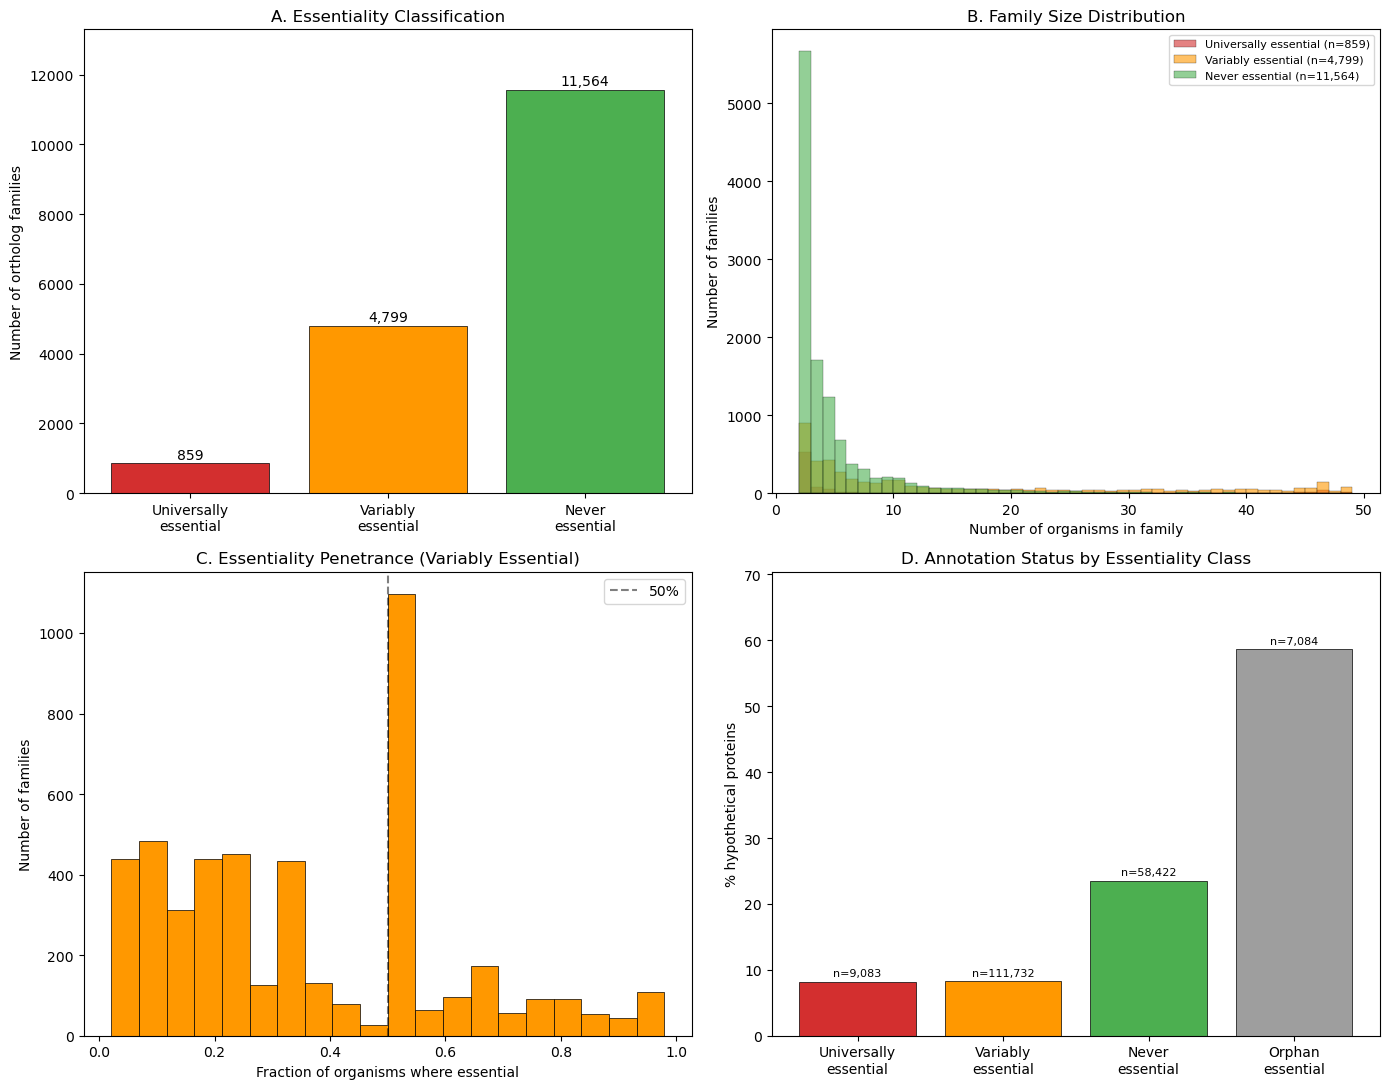

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 11))

class_order = ['universally_essential', 'variably_essential', 'never_essential']
class_labels = ['Universally\nessential', 'Variably\nessential', 'Never\nessential']
class_colors = ['#D32F2F', '#FF9800', '#4CAF50']

# Panel A
ax = axes[0, 0]
counts = [class_counts.get(c, 0) for c in class_order]
bars = ax.bar(class_labels, counts, color=class_colors, edgecolor='black', linewidth=0.5)
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{count:,}', ha='center', va='bottom', fontsize=10)
ax.set_ylabel('Number of ortholog families')
ax.set_title('A. Essentiality Classification')
ax.set_ylim(0, max(counts) * 1.15)

# Panel B
ax = axes[0, 1]
for cls, color, label in zip(class_order, class_colors,
                              ['Universally essential', 'Variably essential', 'Never essential']):
    subset = families[families['essentiality_class'] == cls]
    ax.hist(subset['n_organisms'], bins=range(2, 50), alpha=0.6,
            color=color, label=f'{label} (n={len(subset):,})', edgecolor='black', linewidth=0.3)
ax.set_xlabel('Number of organisms in family')
ax.set_ylabel('Number of families')
ax.set_title('B. Family Size Distribution')
ax.legend(fontsize=8)

# Panel C
ax = axes[1, 0]
ax.hist(var_ess['frac_essential'], bins=20, color='#FF9800', edgecolor='black', linewidth=0.5)
ax.set_xlabel('Fraction of organisms where essential')
ax.set_ylabel('Number of families')
ax.set_title('C. Essentiality Penetrance (Variably Essential)')
ax.axvline(0.5, color='black', linestyle='--', alpha=0.5, label='50%')
ax.legend()

# Panel D
ax = axes[1, 1]
hyp_data = []
for cls, label in zip(class_order + ['orphan'], class_labels + ['Orphan\nessential']):
    if cls == 'orphan':
        subset = ess_not_in_og
    else:
        subset = gene_family_class[gene_family_class['essentiality_class'] == cls]
    n_hyp = subset['desc'].str.contains('hypothetical', case=False, na=False).sum()
    hyp_data.append({'class': label, 'pct_hyp': n_hyp / len(subset) * 100, 'n': len(subset)})
hyp_df = pd.DataFrame(hyp_data)
bars = ax.bar(hyp_df['class'], hyp_df['pct_hyp'],
              color=['#D32F2F', '#FF9800', '#4CAF50', '#9E9E9E'], edgecolor='black', linewidth=0.5)
for bar, row in zip(bars, hyp_df.itertuples()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'n={row.n:,}', ha='center', va='bottom', fontsize=8)
ax.set_ylabel('% hypothetical proteins')
ax.set_title('D. Annotation Status by Essentiality Class')
ax.set_ylim(0, hyp_df['pct_hyp'].max() * 1.2)

plt.tight_layout()
plt.savefig(FIG_DIR / 'essential_families_overview.png', dpi=150, bbox_inches='tight')
plt.show()

## Figure 2: Top 40 universally essential families heatmap

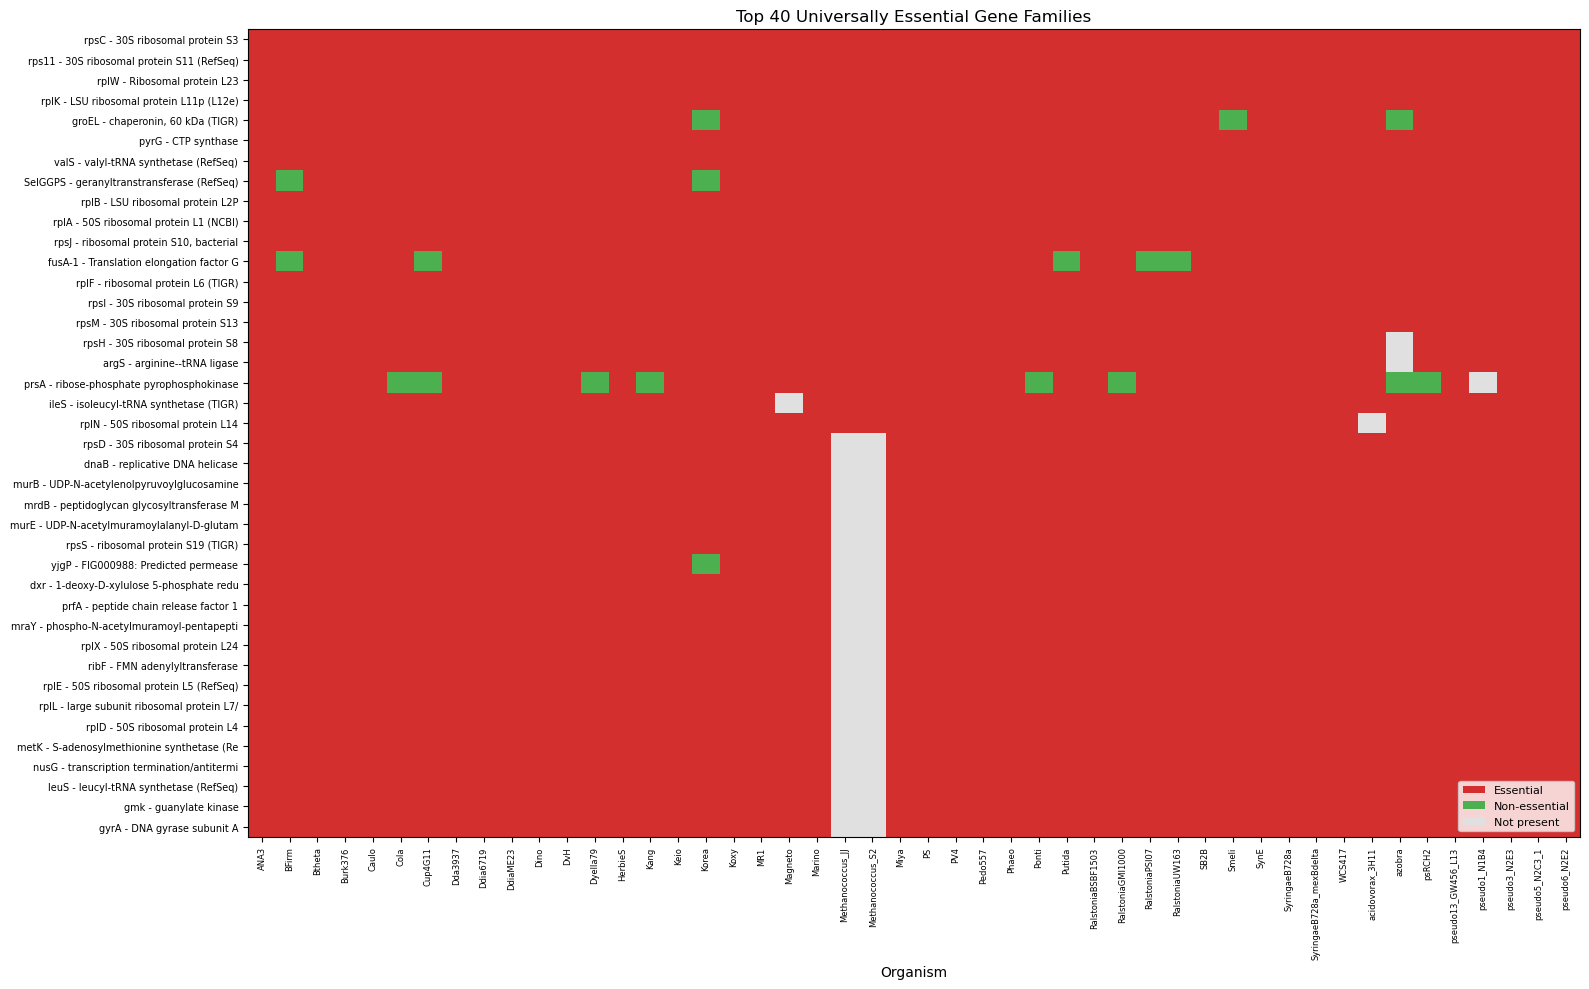

In [10]:
top_univ = univ.sort_values('n_organisms', ascending=False).head(40)
all_orgs_sorted = sorted(essential['orgId'].unique())

fig, ax = plt.subplots(figsize=(16, 10))
heatmap_data = np.full((len(top_univ), len(all_orgs_sorted)), np.nan)
family_labels_list = []

for i, (_, fam) in enumerate(top_univ.iterrows()):
    fam_genes = merged[merged['OG_id'] == fam['OG_id']]
    for _, gene in fam_genes.iterrows():
        if gene['orgId'] in all_orgs_sorted:
            j = all_orgs_sorted.index(gene['orgId'])
            ess_val = gene.get('is_essential', None)
            if pd.notna(ess_val):
                heatmap_data[i, j] = 1 if bool(ess_val) else 0
    gene_name = str(fam['rep_gene'])[:8] if fam['rep_gene'] else ''
    desc_short = str(fam['rep_desc'])[:35]
    family_labels_list.append(f"{gene_name} - {desc_short}" if gene_name else desc_short)

from matplotlib.patches import Patch
cmap = plt.cm.colors.ListedColormap(['#4CAF50', '#D32F2F', '#E0E0E0'])
bounds = [-0.5, 0.5, 1.5, 2.5]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
heatmap_display = np.where(np.isnan(heatmap_data), 2, heatmap_data)

ax.imshow(heatmap_display, aspect='auto', cmap=cmap, norm=norm, interpolation='none')
ax.set_yticks(range(len(family_labels_list)))
ax.set_yticklabels(family_labels_list, fontsize=7)
ax.set_xticks(range(len(all_orgs_sorted)))
ax.set_xticklabels(all_orgs_sorted, rotation=90, fontsize=6)
ax.set_xlabel('Organism')
ax.set_title(f'Top {len(top_univ)} Universally Essential Gene Families')
ax.legend(handles=[Patch(facecolor='#D32F2F', label='Essential'),
                   Patch(facecolor='#4CAF50', label='Non-essential'),
                   Patch(facecolor='#E0E0E0', label='Not present')], loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig(FIG_DIR / 'essential_families_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()